In [1]:
# Import necessary libraries
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import export_text

# Bike Sharing Prediction - Decision Tree

## Import Dataset

In [2]:
local_path='dataset/SeoulBikeData.csv'
auto='auto'
df='SeoulBikeData.csv'

In [3]:
# get current directory
path = os.getcwd()
print("Current Directory", path)
print()
 
# parent directory
parent = os.path.dirname(path)
print("Parent directory", parent)
print()

# dataset path
dataset_path=os.path.join(parent,local_path)
print("Dataset path",dataset_path)
print()

# auto path
path_auto=os.path.join(parent,auto)
print("Dump path",path_auto)

Current Directory /Users/baptistebeaurain/Google Drive/learning/Python/polars_explo/project/bike_sharing/notebook

Parent directory /Users/baptistebeaurain/Google Drive/learning/Python/polars_explo/project/bike_sharing

Dataset path /Users/baptistebeaurain/Google Drive/learning/Python/polars_explo/project/bike_sharing/dataset/SeoulBikeData.csv

Dump path /Users/baptistebeaurain/Google Drive/learning/Python/polars_explo/project/bike_sharing/auto


In [4]:
df=pd.read_csv(dataset_path)
df=df.drop('Date', axis=1)

print("shape:", df.shape)

df.head(5)

shape: (8760, 13)


,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
# Define the bin edges
bin_edges = list(range(0, 10000, 100))

# Create a new column 'Category' by categorizing 'Values' into bins
df['Category'] = pd.cut(df['Rented Bike Count'], bins=bin_edges, labels=False, right=False)
df=df.drop('Rented Bike Count', axis=1)

# Display the result
df.head(5)

,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Category
0,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2
1,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2
2,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,1
3,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1
4,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0


## Decision Tree

### Prepare Train Test Data & Encode

In [6]:
# Separate features (X) and target variable (y)
X = df.drop('Category', axis=1)
y = df['Category']

# Identify categorical columns (you might need to adjust this based on your dataset)
categorical_columns = X.select_dtypes(include=['object']).columns

# Create a ColumnTransformer to apply one-hot encoding to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

### Model Fitting & Result

In [7]:

# Create a pipeline with the preprocessing step and the Decision Tree Classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=10,
        criterion='gini',
        min_samples_leaf=10,
        min_samples_split=10
        ))
])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the classifier on the training set
pipeline.fit(
    X_train, 
    y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)


In [8]:
# Evaluate the model
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.3378995433789954


### Feature Importance

In [9]:
# Access feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame to display feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X.columns), 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the relevant features and their importances
print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
                                Feature  Importance
8                       remainder__Hour    0.311734
9             remainder__Temperature(C)    0.257025
7              cat__Functioning Day_Yes    0.111642
15              remainder__Rainfall(mm)    0.076238
10               remainder__Humidity(%)    0.061670
3                   cat__Seasons_Winter    0.042587
14   remainder__Solar Radiation (MJ/m2)    0.029099
13  remainder__Dew point temperature(C)    0.028208
0                   cat__Seasons_Autumn    0.022447
12          remainder__Visibility (10m)    0.020695
11          remainder__Wind speed (m/s)    0.012195
4                  cat__Holiday_Holiday    0.008840
16             remainder__Snowfall (cm)    0.008739
1                   cat__Seasons_Spring    0.008042
2                   cat__Seasons_Summer    0.000837
6               cat__Functioning Day_No    0.000000
5               cat__Holiday_No Holiday    0.000000


### Tree Visualization

In [10]:
# Print the decision tree rules
tree_rules = export_text(pipeline.named_steps['classifier'], feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X.columns))
print("Decision Tree Rules:")
print(tree_rules)

Decision Tree Rules:
|--- cat__Functioning Day_Yes <= 0.50
|   |--- class: 0
|--- cat__Functioning Day_Yes >  0.50
|   |--- remainder__Temperature(C) <= 3.35
|   |   |--- remainder__Hour <= 6.50
|   |   |   |--- remainder__Hour <= 2.50
|   |   |   |   |--- remainder__Temperature(C) <= -10.10
|   |   |   |   |   |--- remainder__Dew point temperature(C) <= -22.45
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- remainder__Dew point temperature(C) >  -22.45
|   |   |   |   |   |   |--- remainder__Wind speed (m/s) <= 1.70
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- remainder__Wind speed (m/s) >  1.70
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- remainder__Temperature(C) >  -10.10
|   |   |   |   |   |--- cat__Seasons_Autumn <= 0.50
|   |   |   |   |   |   |--- remainder__Temperature(C) <= -0.65
|   |   |   |   |   |   |   |--- remainder__Temperature(C) <= -1.55
|   |   |   |   |   |   |   |   |--- remainder__Humidity(%) <= 61.00
| 

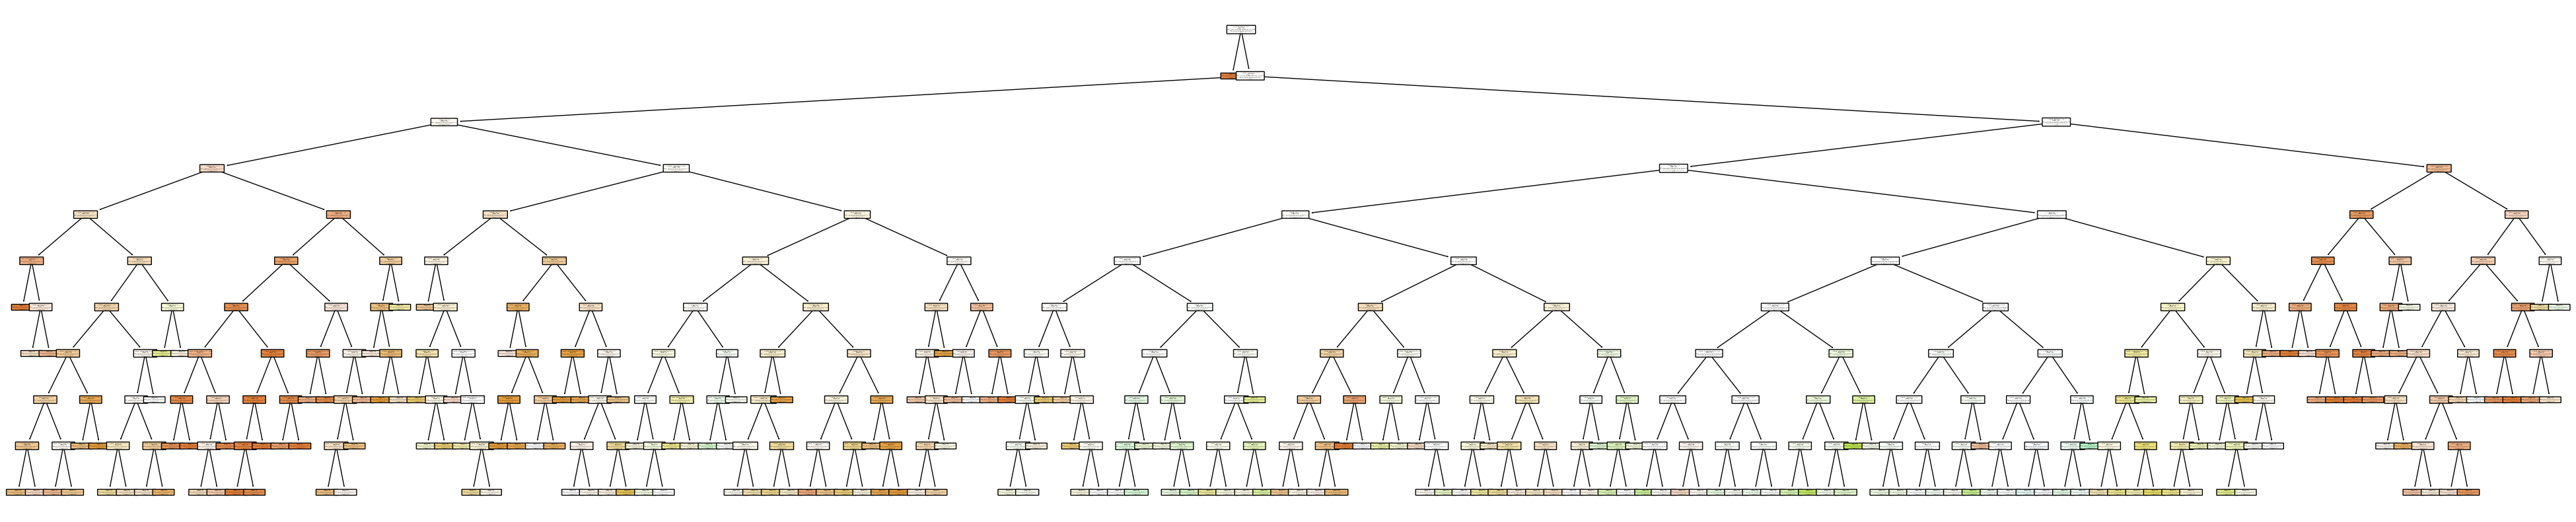

In [11]:
# Visualize the decision tree using plot_tree
plt.figure(figsize=(50, 10))
plot_tree(pipeline.named_steps['classifier'], feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X.columns), class_names=[str(x) for x in pipeline.named_steps['classifier'].classes_], filled=True, rounded=True)
plt.show()

## Tuning Hyper Parameters

In [12]:
# Define the hyperparameters to tune
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 7, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to search for the best combination of hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(),
                                                                         Index(['Seasons', 'Holiday', 'Functioning Day'], dtype='object'))])),
                                       ('classifier',
                                        DecisionTreeClassifier(max_depth=10,
                                                               min_samples_leaf=10,
                                                               min_samples_split=10))]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 5, 7, 10],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [13]:
# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Accuracy: 0.3664383561643836


In [14]:
# Print the decision tree rules of the best model
best_model = grid_search.best_estimator_
tree_rules = export_text(best_model.named_steps['classifier'], feature_names=best_model.named_steps['preprocessor'].get_feature_names_out(input_features=X.columns))
print("Decision Tree Rules:")
print(tree_rules)

Decision Tree Rules:
|--- remainder__Temperature(C) <= 7.45
|   |--- remainder__Hour <= 6.50
|   |   |--- cat__Seasons_Autumn <= 0.50
|   |   |   |--- remainder__Hour <= 2.50
|   |   |   |   |--- remainder__Temperature(C) <= -6.40
|   |   |   |   |   |--- remainder__Dew point temperature(C) <= -22.95
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- remainder__Dew point temperature(C) >  -22.95
|   |   |   |   |   |   |--- remainder__Temperature(C) <= -6.95
|   |   |   |   |   |   |   |--- remainder__Wind speed (m/s) <= 0.65
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- remainder__Wind speed (m/s) >  0.65
|   |   |   |   |   |   |   |   |--- remainder__Hour <= 1.50
|   |   |   |   |   |   |   |   |   |--- remainder__Humidity(%) <= 43.00
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- remainder__Humidity(%) >  43.00
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   | 

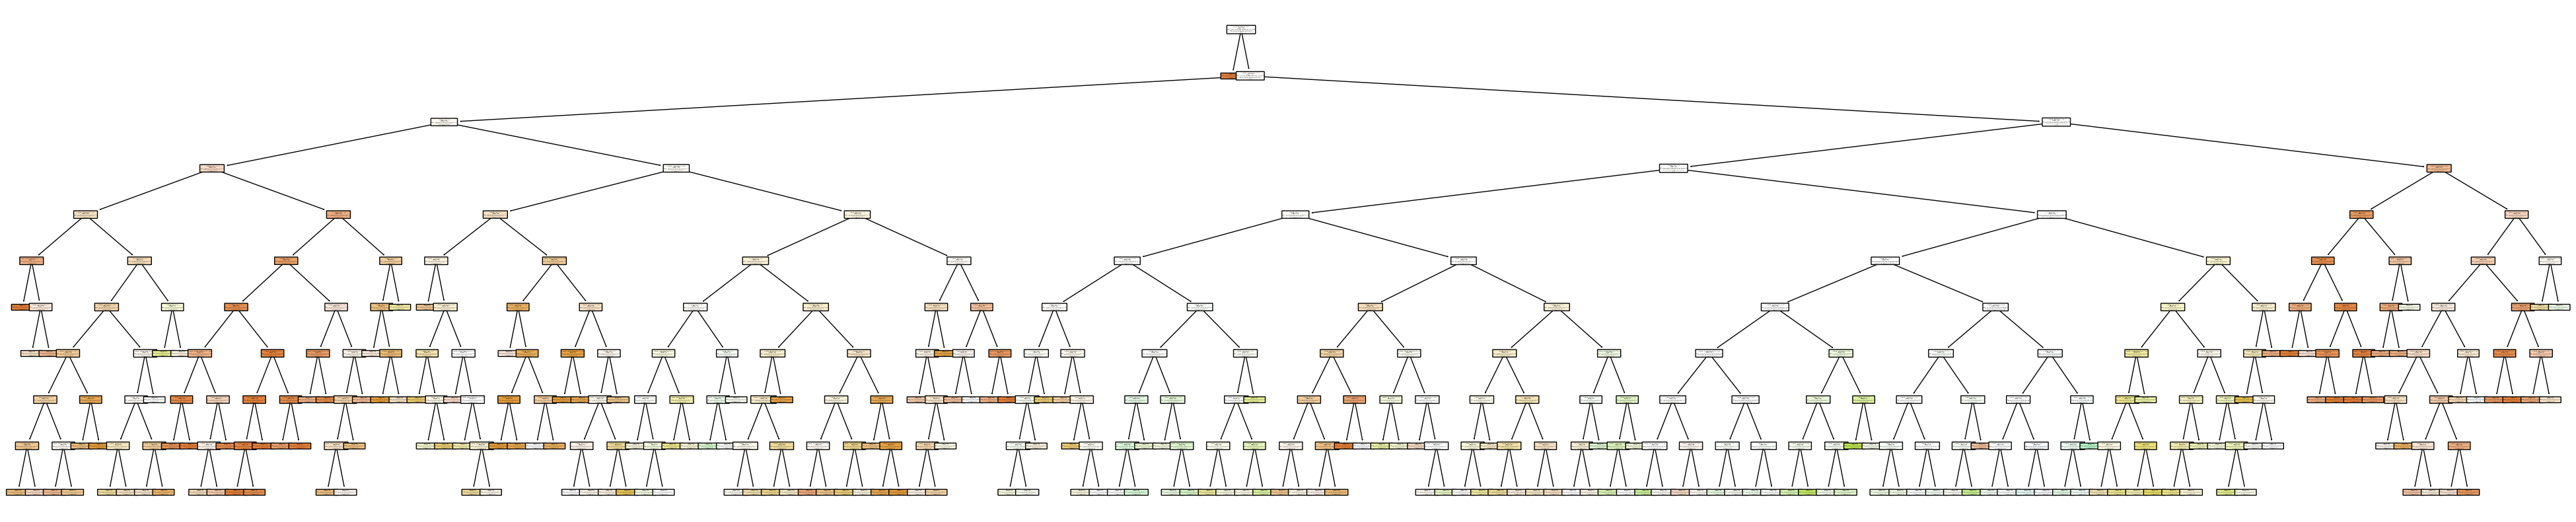

In [15]:
# Visualize the decision tree using plot_tree
plt.figure(figsize=(50, 10))
plot_tree(pipeline.named_steps['classifier'], feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X.columns), class_names=[str(x) for x in pipeline.named_steps['classifier'].classes_], filled=True, rounded=True)
plt.show()